<a href="https://colab.research.google.com/github/gunjansa/schoolofai/blob/main/Modular_SchoolOfAISession_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CODE BLOCK: 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

CUDA Available? True


device(type='cuda')

CODE BLOCK: 3

In [ ]:
# Train data transformations
# We train on complicated data by applying transformations to introduce Noise
train_transforms = transforms.Compose([
    # This is applied to introduce some noise (like, Masking).
    # Example, if training is done to predict  Nurse from hospital teachers.
    # Then, model could be biased that by looking females it just predicts Nurse.
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    # There are chances that images are rotated. Like, if 7 is rotated it might predict as 1
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    # In general we do normalize all the images with Mean and Standard Deviation. Why? Need to see previous lecture
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
# In test data, we don't apply transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1407,), (0.4081,))
    ])

CODE BLOCK: 4

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
# Changed
# test_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

In [ ]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

# test_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

In [ ]:
# batch_data, batch_label = next(iter(train_loader))
len(train_data[1][0][0][0])

28

In [ ]:
train_data[1][0][0][0]

tensor([-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
        -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
        -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
        -0.4242, -0.4242, -0.4242, -0.4242])

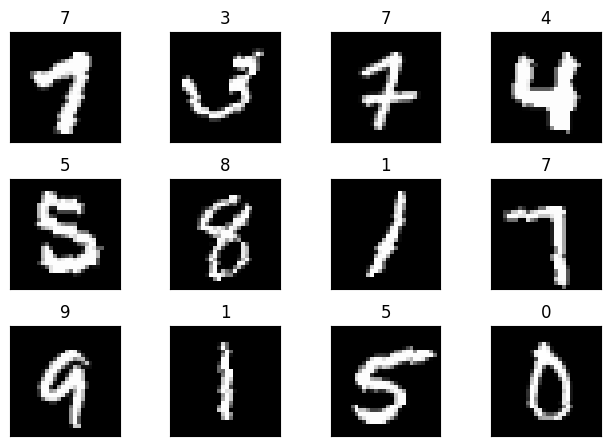

In [ ]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [ ]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(4096, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x), 2)
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        # x = F.relu(F.max_pool2d(x, 2))
        # x = F.relu(F.max_pool2d(x, 2))
        x = x.view(len(x), 4096)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Layer structure or architecture
# 28x28x1
# 26x26x32
# 24x24x64
# 12x12x64
# 10x10x128
# 8x8x256
# 4x4x256
# 320x50
# 50x10

CODE BLOCK: 8

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [ ]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            # test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [ ]:
model = Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=10.01, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.3953 Batch_id=117 Accuracy=55.61: 100%|██████████| 118/118 [00:22<00:00,  5.35it/s]


Test set: Average loss: 0.0006, Accuracy: 54685/60000 (91.14%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1775 Batch_id=117 Accuracy=94.19: 100%|██████████| 118/118 [00:23<00:00,  4.96it/s]


Test set: Average loss: 0.0003, Accuracy: 57551/60000 (95.92%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1042 Batch_id=117 Accuracy=96.52: 100%|██████████| 118/118 [00:23<00:00,  5.07it/s]


Test set: Average loss: 0.0002, Accuracy: 58217/60000 (97.03%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.2255 Batch_id=117 Accuracy=97.18: 100%|██████████| 118/118 [00:21<00:00,  5.39it/s]


Test set: Average loss: 0.0002, Accuracy: 58446/60000 (97.41%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0298 Batch_id=117 Accuracy=97.41: 100%|██████████| 118/118 [00:22<00:00,  5.32it/s]


Test set: Average loss: 0.0001, Accuracy: 58627/60000 (97.71%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0222 Batch_id=117 Accuracy=97.81: 100%|██████████| 118/118 [00:26<00:00,  4.41it/s]


Test set: Average loss: 0.0001, Accuracy: 58859/60000 (98.10%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0875 Batch_id=117 Accuracy=98.03: 100%|██████████| 118/118 [00:23<00:00,  5.01it/s]


Test set: Average loss: 0.0001, Accuracy: 58897/60000 (98.16%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0244 Batch_id=117 Accuracy=98.17: 100%|██████████| 118/118 [00:23<00:00,  4.99it/s]


Test set: Average loss: 0.0001, Accuracy: 58967/60000 (98.28%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0199 Batch_id=117 Accuracy=98.38: 100%|██████████| 118/118 [00:26<00:00,  4.46it/s]


Test set: Average loss: 0.0001, Accuracy: 59100/60000 (98.50%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0377 Batch_id=117 Accuracy=98.50: 100%|██████████| 118/118 [00:25<00:00,  4.68it/s]


Test set: Average loss: 0.0001, Accuracy: 59159/60000 (98.60%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0820 Batch_id=117 Accuracy=98.56: 100%|██████████| 118/118 [00:22<00:00,  5.21it/s]


Test set: Average loss: 0.0001, Accuracy: 59151/60000 (98.58%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0447 Batch_id=117 Accuracy=98.72: 100%|██████████| 118/118 [00:26<00:00,  4.42it/s]


Test set: Average loss: 0.0001, Accuracy: 59178/60000 (98.63%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0411 Batch_id=117 Accuracy=98.69: 100%|██████████| 118/118 [00:23<00:00,  4.95it/s]


Test set: Average loss: 0.0001, Accuracy: 59303/60000 (98.84%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0223 Batch_id=117 Accuracy=98.80: 100%|██████████| 118/118 [00:26<00:00,  4.52it/s]


Test set: Average loss: 0.0001, Accuracy: 59355/60000 (98.92%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.1300 Batch_id=117 Accuracy=98.89: 100%|██████████| 118/118 [00:22<00:00,  5.31it/s]


Test set: Average loss: 0.0001, Accuracy: 59388/60000 (98.98%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0099 Batch_id=117 Accuracy=99.07: 100%|██████████| 118/118 [00:22<00:00,  5.22it/s]


Test set: Average loss: 0.0001, Accuracy: 59502/60000 (99.17%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0030 Batch_id=117 Accuracy=99.16: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


Test set: Average loss: 0.0001, Accuracy: 59487/60000 (99.14%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0023 Batch_id=117 Accuracy=99.14: 100%|██████████| 118/118 [00:25<00:00,  4.63it/s]


Test set: Average loss: 0.0001, Accuracy: 59498/60000 (99.16%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0090 Batch_id=117 Accuracy=99.19: 100%|██████████| 118/118 [00:23<00:00,  4.99it/s]


Test set: Average loss: 0.0001, Accuracy: 59528/60000 (99.21%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0234 Batch_id=117 Accuracy=99.19: 100%|██████████| 118/118 [00:23<00:00,  5.03it/s]


Test set: Average loss: 0.0001, Accuracy: 59514/60000 (99.19%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

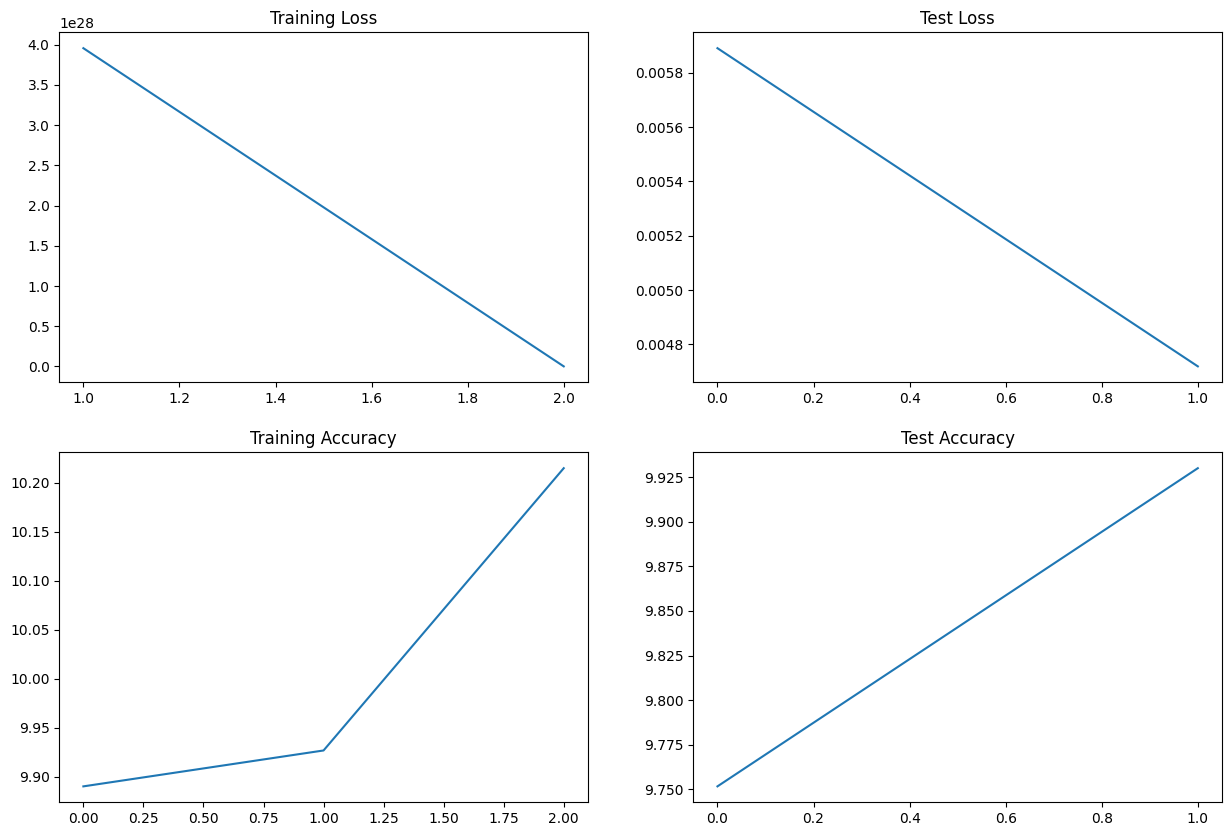

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [ ]:
t = torch.tensor(
    [[[1,1,0,2],
    [0,3,3,0],
    [4,0,2,5]],
    [[4,0,3,1],
    [0,7,7,0],
    [1,0,6,2]]])
t

tensor([[[1, 1, 0, 2],
         [0, 3, 3, 0],
         [4, 0, 2, 5]],

        [[4, 0, 3, 1],
         [0, 7, 7, 0],
         [1, 0, 6, 2]]])

In [ ]:
t.max(dim=2)

torch.return_types.max(
values=tensor([[2, 3, 5],
        [4, 7, 6]]),
indices=tensor([[3, 1, 3],
        [0, 1, 2]]))

In [ ]:
tt = torch.tensor([[1, 0, 0, 2], [0,3,3,0]]) # [x1, y1, z1, v1], [x2, y2, z2, v2]
tt

tensor([[1, 0, 0, 2],
        [0, 3, 3, 0]])

In [ ]:
tt.max(dim=0)

torch.return_types.max(
values=tensor([1, 3, 3, 2]),
indices=tensor([0, 1, 1, 0]))